# Setup

In [11]:
# import os
# os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

# import jax
import jax
jax.config.update('jax_platform_name', 'cpu')
# print("jax version:", jax.__version__)
# print("jax devices:", jax.devices())
import jax.numpy as jnp
import numpy as np
import functools
import abc
import torch
import torch.nn as nn

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import pypalettes
import matplotlib.patches as patches

import hj_reachability as hj
from hj_reachability.finite_differences import upwind_first

from hjnnv import hjnnvUncertaintyAwareFilter
from dynamic_models.beacon import BeaconDynamics
from simulators.beacon_env.desired_trajectories import DesiredTrajectory


# jax.config.update("jax_cudnn_use_autotuned", False)
import warnings
warnings.filterwarnings("ignore", category=ResourceWarning)

In [2]:
def rov_controller(state, desired_traj, time, kp=3.0, kd=0.5):
    spline_x, spline_y = desired_traj.generate_trajectory()
    ax_des = spline_x(time, 2)
    ay_des = spline_y(time, 2)
    vx_des = spline_x(time, 1)
    vy_des = spline_y(time, 1)
    x_des = spline_x(time)
    y_des = spline_y(time)

    # kp = 3.0  # Control gain
    # kd = 1.0*0.5  # Derivative gain

    ux = ax_des + kp * (x_des - state[0]) + kd * (vx_des - state[2])
    uy = ay_des + kp * (y_des - state[1]) + kd * (vy_des - state[3])

    u = jnp.array([ux, uy])
    u_clipped = jnp.clip(u, -1.0, 1.0)
    return u_clipped

In [4]:
def fgsm(model, target, observation, epsilon=0.1, loss_fn=lambda x, y: jnp.mean((x - y) ** 2)):
    # observation must have requires_grad equivalent: use jax.grad w.r.t. observation
    grad_fn = jax.grad(lambda obs: loss_fn(model(obs), target))
    grad = grad_fn(observation)
    perturbation = - epsilon * jnp.sign(grad)
    adv_observation = observation + perturbation

    return adv_observation

@functools.partial(jax.jit, static_argnames=['model', 'loss_fn', 'iters', 'alpha', 'epsilon'])
def pgd(model, target, observation, epsilon=0.1, alpha=0.01, iters=40, loss_fn=lambda x,y: jnp.mean((x-y)**2)):
    adv = observation.copy()
    for _ in range(iters):
        grad = jax.grad(lambda o: loss_fn(model(o), target))(adv)
        adv = adv - alpha * jnp.sign(grad)   # take a small FGSM step
    adv = jnp.clip(adv, observation - epsilon, observation + epsilon)  # project into ε-ball
    return adv

In [47]:
def run_simulation(hjnnv_filter, seed=0, epsilon=0.1, smoothing=True, filter_type="hjnnv_bestu", attack=False, traj_type="spiral", hj_mode="estimate"):
    dynamics = hjnnv_filter.dynamics
    # Good set of experiments to show: No filter, HJ, HJNNV bestu
    sample_type = "observations"

    history = {
        "state": [],
        "state_hat": [],
        "state_bounds": [],
        "state_samples": [],
        "state_des": []
    }
    state_history = []
    state_hat_history = []
    state_bounds_history = []
    state_sample_history = []
    state_des_history = []

    key = jax.random.PRNGKey(seed)
    num_samples = 5000
    dynamics.set_random_seed(seed)

    if traj_type == "lawnmower":
        state = jnp.array([0.5, 0.5, 0.0, 0.0])  # initial state
        num_steps = 1650
    elif traj_type == "spiral":
        state = jnp.array([5., 5., 0.0, 0.0])
        # num_steps = 650
        # num_steps = 700
        num_steps = 375
    elif traj_type == "circle":
        state = jnp.array([8., 5., 0.0, 0.0])
        num_steps = 650
    else:
        state = jnp.array([5.0, 5.0, 0.0, 0.0])  # initial state
        num_steps = 650

    desired_traj = DesiredTrajectory(traj_type)
    state_hat = state
    u = rov_controller(state_hat, desired_traj, 0, kp=2.0, kd=0.5)

    for step in range(num_steps):
        key, subkey = jax.random.split(key)
        t = step * dynamics.dt
        # Simulate the system dynamics
        obs_ = dynamics.get_observation(state, time=step)
        if attack and jnp.linalg.norm(state[:2] - jnp.array([5., 5.])) > 3.0:
            target = jnp.array([5., 5., state_hat[2], state_hat[3]])
            obs = fgsm(model=dynamics.get_state_estimate, target=target, observation=obs_ , epsilon=epsilon)
        else:
            obs = obs_
        
        # obs = pgd(model=dynamics.get_state_estimate, target=target, observation=obs_, epsilon=epsilon, alpha=0.02, iters=10)
        if smoothing:
            est_obs = jnp.concatenate([state_hat, u, obs])  # append previous state estimate and input
            state_hat = dynamics.get_smoothed_state_distance_estimate(est_obs).flatten()
        else:
            state_hat = dynamics.get_state_estimate(obs).flatten()
            
        u_nominal = rov_controller(state_hat, desired_traj, t)

        time_start = time.time()
        if filter_type == "hjnnv_maxval" or filter_type == "hjnnv_bestu":
            if smoothing:
                bound_epsilon = jnp.concatenate([1e-8*jnp.ones(6,), epsilon*jnp.ones(12,)])
                state_bounds = hjnnv_filter.nnv_state_bounds(
                    obs=est_obs,
                    eps=bound_epsilon
                )
            else:
                state_bounds = hjnnv_filter.nnv_state_bounds(
                    obs=obs,
                    eps=epsilon
                )

            # if epsilon == 0.1:
            pos_buffer = 5e-2
            vel_buffer = 6.5e-1
            # else:
            #     pos_buffer = 0
            #     vel_buffer = 0
            state_bounds = hj.sets.Box(
                lo=state_bounds.lo - jnp.array([pos_buffer, pos_buffer, vel_buffer, vel_buffer]),
                hi=state_bounds.hi + jnp.array([pos_buffer, pos_buffer, vel_buffer, vel_buffer])
            )

            if filter_type == "hjnnv_maxval":
                v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                    u_nominal,
                    state_bounds,
                    num_states=2,
                    eps=1e-6
                )
            elif filter_type == "hjnnv_bestu":
                v_star, u_star, worst_val, val_filter, min_vals, distances, _, _, = hjnnv_filter.ua_filter_best_u(
                    u_nominal,
                    state_bounds,
                    num_states=2,
                    delta=0.01
                )
        elif filter_type == "hj":
            # obs_perturbations = jax.random.uniform(
            #     subkey, shape=(num_samples, obs.shape[0]),
            #     minval=-epsilon, maxval=epsilon
            # )
            # obs_samples = obs + obs_perturbations
            # state_samples_0 = jax.vmap(lambda o: dynamics.get_state_estimate(o).flatten())(obs_samples)
            # # With probability 0.5, pick the state sample furthest from (5,5,0,0), otherwise leave unchanged
            # if jax.random.uniform(subkey) < 0.8:
            #     ref_point = jnp.array([5., 5., 0., 0.])
            #     distances = jnp.linalg.norm(state_samples_0 - ref_point, axis=1)
            #     furthest_idx = jnp.argmin(distances)
            #     state_hat = state_samples_0[furthest_idx]
            if hj_mode == "estimate":
                lo = state_hat - 1e-8
                hi = state_hat + 1e-8
            elif hj_mode == "gt":
                lo = state - 1e-8
                hi = state + 1e-8
            state_bounds = hj.sets.Box(
                lo,
                hi
            )
            v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                u_nominal,
                state_bounds,
                num_states=2
            )
        elif filter_type == "none":
            u = u_nominal
            v_star = 0.0
            val_filter = 1.0  # positive value means no filtering
            lo = state_hat - 1e-8
            hi = state_hat + 1e-8
            state_bounds = hj.sets.Box(
                lo,
                hi
            )

        if val_filter < 0.0:
            u = u_star
            # print(f"Step {step}: Using filtered control u_star={u}, val_filter={val_filter}")
            # mask = min_vals >= (v_star - 1e-7)  # candidates within tolerance
            # print(f"Step {step}: min_vals_masked={jnp.where(mask, distances, jnp.inf)}")
            # best_idx = jnp.argmin(jnp.where(mask, distances, jnp.inf))
            # print(f"Step {step}: best_idx={best_idx}, u_best={hjnnv_filter.control_vals[best_idx]}, v_best={min_vals[best_idx]}, dist_best={distances[best_idx]}")
            # print(f"Step {step}: Max min_vals={max(min_vals)}")
        else:
            u = u_nominal
        time_end = time.time()

        obs_perturbations = jax.random.uniform(
            subkey, shape=(num_samples, obs.shape[0]),
            minval=-epsilon, maxval=epsilon
        )
        obs_samples = obs + obs_perturbations

        if sample_type == "observations":
            state_samples_0 = jax.vmap(lambda o: dynamics.get_state_estimate(o).flatten())(obs_samples)
        elif sample_type == "state_bounds":
            state_samples_0 = jax.random.uniform(
                subkey, shape=(num_samples, state.shape[0]),
                minval=state_bounds.lo, maxval=state_bounds.hi
            )

        disturbances = jax.vmap(lambda k: dynamics.get_random_disturbance())(
            jax.random.split(subkey, num_samples)
        )

        state_samples = jax.vmap(
            lambda s, d: dynamics.step(s, u_nominal, d, time=step)
        )(state_samples_0, disturbances)

        state_sample_history.append(state_samples)

        # print(f"Step {step}: State: {state}")
        # print(f"Step {step}: Estimated State: {state_hat}")

        # print(f"Step {step}: best_val={v_star}")
        # print(f"Step {step}: state_bounds={state_bounds}")
        print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")
        # if step > 194:
        #     print(f"Step {step}: min_vals={min_vals}")

        # Store the state
        # if step == 0:
        state_history.append(state)
        state_hat_history.append(state_hat)
        state_bounds_history.append(state_bounds)
        spline_x, spline_y = desired_traj.generate_trajectory()
        state_des_history.append(jnp.array([spline_x(t, 0), spline_y(t, 0), spline_x(t, 1), spline_y(t, 1)]))

        state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

    history["state"] = state_history
    history["state_hat"] = state_hat_history
    history["state_bounds"] = state_bounds_history
    history["state_samples"] = state_sample_history
    history["state_des"] = state_des_history
    history["filter_type"] = filter_type
    history["epsilon"] = epsilon
    history["attack"] = attack
    return history

In [19]:

def plot_trajectory(history, dynamics):
    rgb_colors = np.array(pypalettes.load_cmap("Color_Blind").rgb)/255.0

    state_history = history["state"]
    state_hat_history = history["state_hat"]
    state_bounds_history = history["state_bounds"]
    state_sample_history = history["state_samples"]
    state_des_history = history["state_des"]
    epsilon = history["epsilon"]
    attack = history["attack"]
    filter_type = history["filter_type"]

    darkblue = list(rgb_colors[0])
    orange = list(rgb_colors[1])
    med_grey = list(rgb_colors[2])
    dark_grey = list(rgb_colors[3])
    lightblue = list(rgb_colors[4])
    red = list(rgb_colors[5])
    darkmed_grey = list(rgb_colors[6])
    lightlightblue = list(rgb_colors[7])


    state_history = jnp.stack(state_history)
    state_hat_history = jnp.stack(state_hat_history)
    state_des_history = jnp.stack(state_des_history)

    # t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)
    # x_des_history = spline_x(t_samples, 0)
    # y_des_history = spline_y(t_samples, 0)



    plt.figure(figsize=(10, 8))
    plt.plot(state_history[:, 0], state_history[:, 1], label="True State Trajectory", c=darkblue)
    plt.plot(state_hat_history[:, 0], state_hat_history[:, 1], label="Estimated State Trajectory", c=orange)
    plt.plot(state_des_history[:, 0], state_des_history[:, 1], label="Desired State Trajectory", c=dark_grey, linestyle='--')
    plt.scatter(dynamics.beacons[:, 0], dynamics.beacons[:, 1], color=dark_grey, marker='o', label="Beacons", s=100)


    plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=med_grey, facecolor='none', label="Safe Boundary"))

    for i in range(len(state_bounds_history)):
        bounds = state_bounds_history[i]
        lo = bounds.lo
        hi = bounds.hi
        if i == len(state_bounds_history) - 1:
            rect = plt.Rectangle(
                (lo[0], lo[1]),
                hi[0] - lo[0],
                hi[1] - lo[1],
                linewidth=1,
                edgecolor=lightblue + [0.75],
                facecolor=lightblue + [0.25],
                label="State Bounds",
                zorder=0
            )
        else:
            rect = plt.Rectangle(
                (lo[0], lo[1]),
                hi[0] - lo[0],
                hi[1] - lo[1],
                linewidth=1,
                edgecolor=lightblue + [0.75],
                facecolor=lightblue + [0.05],
                zorder=0
            )
        plt.gca().add_patch(rect)
    plt.xlabel("x position")
    plt.ylabel("y position")
    plt.title("{} Filtering with {} perturbations; attack={}".format(filter_type, epsilon, attack))
    plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
    plt.xlim(-1, 11)
    plt.ylim(-1, 11)
    # plt.grid(True)
    plt.show()

# HJ vs HJNNV

In [51]:
epsilon = 0.04
smoothing = True
smoothing_alpha = 0.7
dt = 0.1
max_input = 3.0
max_position_disturbance = 0.1
max_vel_disturbance = 0.01
seed = 0
model_name="simple_estimator_3t_long_range"
# model_name="simple_estimator_3t"

dynamics = BeaconDynamics(
    dt=dt,
    max_input=max_input,
    max_position_disturbance=max_position_disturbance,
    max_vel_disturbance=max_vel_disturbance,
    range_disturbance=epsilon,
    model_name=model_name,
    random_seed=seed
)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
            hj.sets.Box(
                np.array([-5., -5., -5., -5.]),
                np.array([15., 15., 5., 5.])),
            (30, 30, 20, 20),
        )
values_ = jnp.stack([jnp.abs(grid.states[..., 0] - 5.), jnp.abs(grid.states[..., 1] - 5.)], axis=-1)
values = -jnp.max(values_, axis=-1) + 5.

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
cmap = 'viridis'

if smoothing:
    estimation_function = functools.partial(dynamics.get_smoothed_state_distance_estimate, alpha=smoothing_alpha)
else:
    estimation_function = dynamics.get_state_estimate

hjnnv_filter = hjnnvUncertaintyAwareFilter(
    dynamics=dynamics,
    pred_model=estimation_function,
    grid=grid,
    initial_values=values,
    num_controls=30,
    num_disturbances=2
)



100%|##########| 10.0000/10.0 [00:45<00:00,  4.52s/sim_s]


/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)
/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)
/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)
/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_mi

Step 0: Filter execution time: 1.75415 seconds
Step 1: Filter execution time: 0.00737 seconds
Step 2: Filter execution time: 0.00527 seconds
Step 3: Filter execution time: 0.00628 seconds
Step 4: Filter execution time: 0.00645 seconds
Step 5: Filter execution time: 0.00556 seconds
Step 6: Filter execution time: 0.00649 seconds
Step 7: Filter execution time: 0.00638 seconds
Step 8: Filter execution time: 0.00593 seconds
Step 9: Filter execution time: 0.00574 seconds
Step 10: Filter execution time: 0.00544 seconds
Step 11: Filter execution time: 0.00597 seconds
Step 12: Filter execution time: 0.00551 seconds
Step 13: Filter execution time: 0.00509 seconds
Step 14: Filter execution time: 0.00569 seconds
Step 15: Filter execution time: 0.00480 seconds
Step 16: Filter execution time: 0.00631 seconds
Step 17: Filter execution time: 0.00552 seconds
Step 18: Filter execution time: 0.00553 seconds
Step 19: Filter execution time: 0.00658 seconds
Step 20: Filter execution time: 0.00658 seconds
St

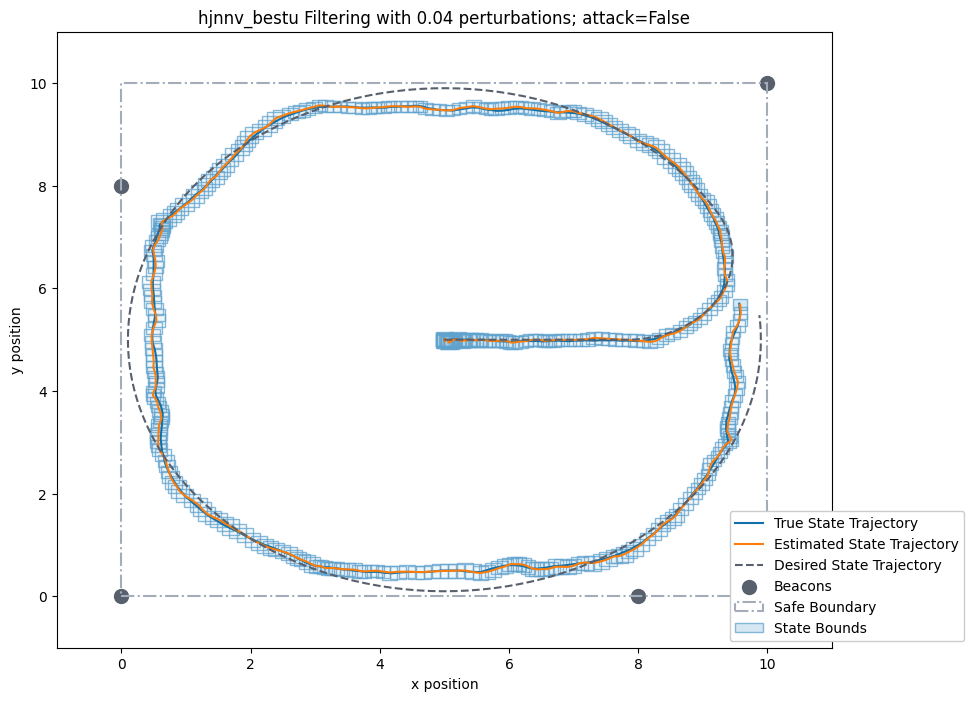

In [36]:
hjnnv_history = run_simulation(hjnnv_filter, seed=0, epsilon=epsilon, smoothing=smoothing, filter_type="hjnnv_bestu", traj_type="spiral")
plot_trajectory(hjnnv_history, dynamics)

Step 0: Filter execution time: 0.00319 seconds
Step 1: Filter execution time: 0.00382 seconds
Step 2: Filter execution time: 0.00219 seconds
Step 3: Filter execution time: 0.00254 seconds
Step 4: Filter execution time: 0.00280 seconds
Step 5: Filter execution time: 0.00256 seconds
Step 6: Filter execution time: 0.00273 seconds
Step 7: Filter execution time: 0.00303 seconds
Step 8: Filter execution time: 0.00309 seconds
Step 9: Filter execution time: 0.00327 seconds
Step 10: Filter execution time: 0.00347 seconds
Step 11: Filter execution time: 0.00296 seconds
Step 12: Filter execution time: 0.00235 seconds
Step 13: Filter execution time: 0.00637 seconds
Step 14: Filter execution time: 0.00635 seconds
Step 15: Filter execution time: 0.00319 seconds
Step 16: Filter execution time: 0.00310 seconds
Step 17: Filter execution time: 0.00299 seconds
Step 18: Filter execution time: 0.00235 seconds
Step 19: Filter execution time: 0.00215 seconds
Step 20: Filter execution time: 0.00280 seconds
St

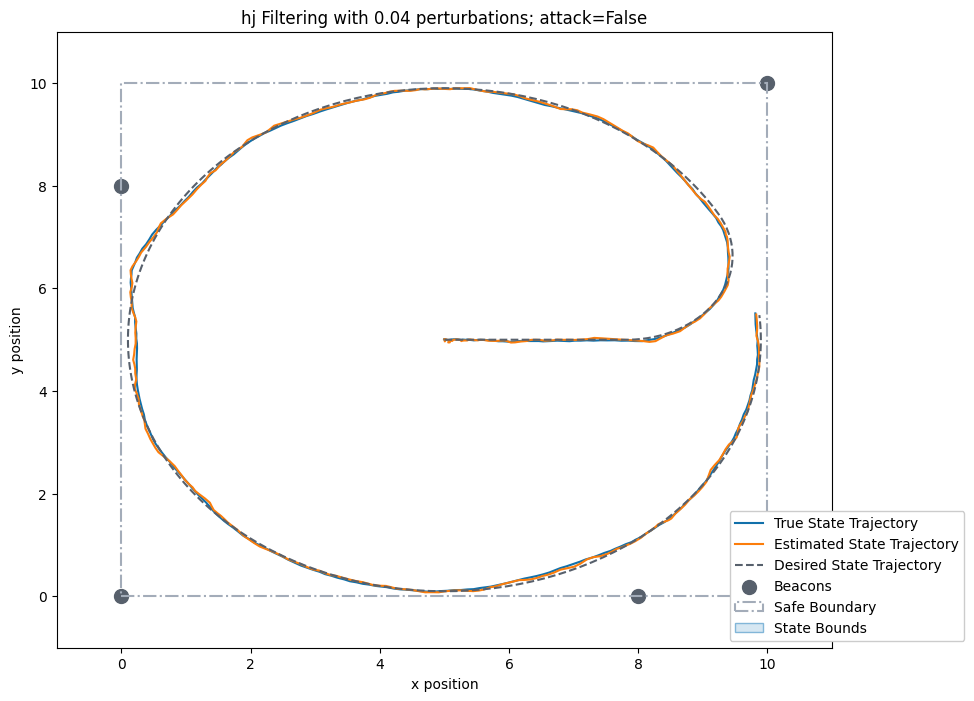

In [37]:
hj_history = run_simulation(hjnnv_filter, seed=0, epsilon=epsilon, smoothing=smoothing, filter_type="hj", traj_type="spiral")
plot_trajectory(hj_history, dynamics)

Step 0: Filter execution time: 0.40716 seconds
Step 1: Filter execution time: 0.00293 seconds
Step 2: Filter execution time: 0.00364 seconds
Step 3: Filter execution time: 0.00297 seconds
Step 4: Filter execution time: 0.00262 seconds
Step 5: Filter execution time: 0.00285 seconds
Step 6: Filter execution time: 0.00295 seconds
Step 7: Filter execution time: 0.00298 seconds
Step 8: Filter execution time: 0.00306 seconds
Step 9: Filter execution time: 0.00303 seconds
Step 10: Filter execution time: 0.00224 seconds
Step 11: Filter execution time: 0.00265 seconds
Step 12: Filter execution time: 0.00230 seconds
Step 13: Filter execution time: 0.00317 seconds
Step 14: Filter execution time: 0.00311 seconds
Step 15: Filter execution time: 0.00235 seconds
Step 16: Filter execution time: 0.00310 seconds
Step 17: Filter execution time: 0.00293 seconds
Step 18: Filter execution time: 0.00303 seconds
Step 19: Filter execution time: 0.00309 seconds
Step 20: Filter execution time: 0.00313 seconds
St

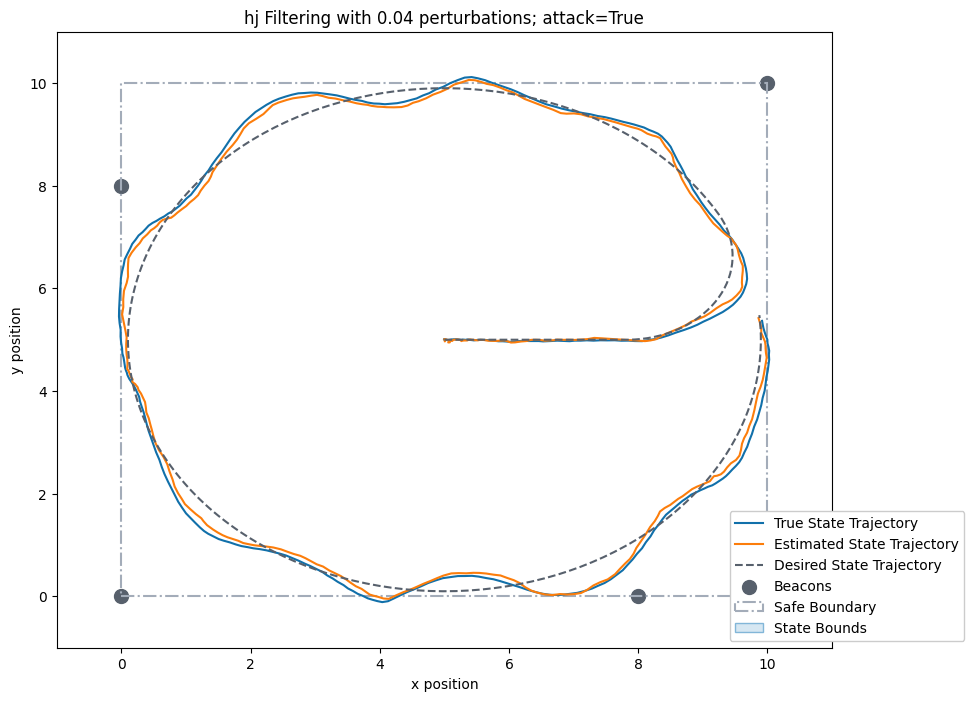

In [52]:
hj_history_atk = run_simulation(hjnnv_filter, seed=0, epsilon=epsilon, smoothing=smoothing, filter_type="hj", traj_type="spiral", attack=True)
plot_trajectory(hj_history_atk, dynamics)

/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)
/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)
/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)
/home/nick/.pyenv/versions/3.10.3/envs/hjnnv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: DeprecationWarning: Passing arguments 'a', 'a_mi

Step 0: Filter execution time: 1.43468 seconds
Step 1: Filter execution time: 0.01179 seconds
Step 2: Filter execution time: 0.00519 seconds
Step 3: Filter execution time: 0.00513 seconds
Step 4: Filter execution time: 0.01308 seconds
Step 5: Filter execution time: 0.00674 seconds
Step 6: Filter execution time: 0.00553 seconds
Step 7: Filter execution time: 0.00586 seconds
Step 8: Filter execution time: 0.00688 seconds
Step 9: Filter execution time: 0.00619 seconds
Step 10: Filter execution time: 0.00516 seconds
Step 11: Filter execution time: 0.00650 seconds
Step 12: Filter execution time: 0.00498 seconds
Step 13: Filter execution time: 0.00576 seconds
Step 14: Filter execution time: 0.00551 seconds
Step 15: Filter execution time: 0.00619 seconds
Step 16: Filter execution time: 0.00565 seconds
Step 17: Filter execution time: 0.00557 seconds
Step 18: Filter execution time: 0.00508 seconds
Step 19: Filter execution time: 0.00554 seconds
Step 20: Filter execution time: 0.00527 seconds
St

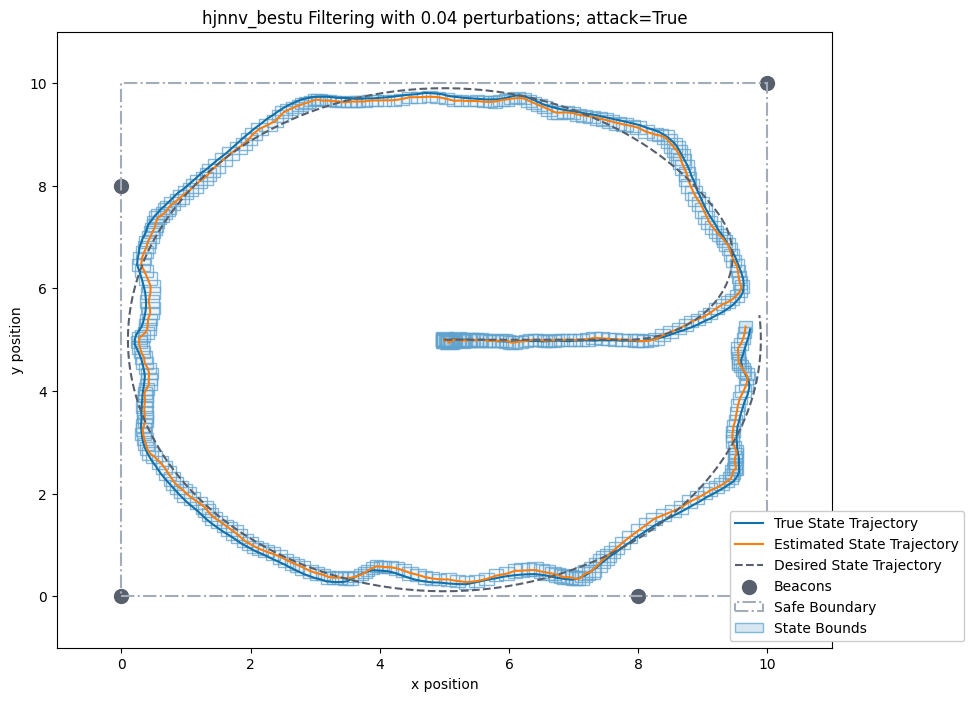

In [53]:
hjnnv_history_atk = run_simulation(hjnnv_filter, seed=0, epsilon=epsilon, smoothing=smoothing, filter_type="hjnnv_bestu", traj_type="spiral", attack=True)
plot_trajectory(hjnnv_history_atk, dynamics)

In [39]:
epsilon = 0.1
smoothing = True
smoothing_alpha = 0.7
dt = 0.1
max_input = 3.0
max_position_disturbance = 0.1
max_vel_disturbance = 0.01
seed = 0
model_name="simple_estimator_3t_long_range"
# model_name="simple_estimator_3t"

dynamics = BeaconDynamics(
    dt=dt,
    max_input=max_input,
    max_position_disturbance=max_position_disturbance,
    max_vel_disturbance=max_vel_disturbance,
    range_disturbance=epsilon,
    model_name=model_name,
    random_seed=seed
)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
            hj.sets.Box(
                np.array([-5., -5., -5., -5.]),
                np.array([15., 15., 5., 5.])),
            (30, 30, 20, 20),
        )
values_ = jnp.stack([jnp.abs(grid.states[..., 0] - 5.), jnp.abs(grid.states[..., 1] - 5.)], axis=-1)
values = -jnp.max(values_, axis=-1) + 5.

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
cmap = 'viridis'

if smoothing:
    estimation_function = functools.partial(dynamics.get_smoothed_state_distance_estimate, alpha=smoothing_alpha)
else:
    estimation_function = dynamics.get_state_estimate

hjnnv_filter = hjnnvUncertaintyAwareFilter(
    dynamics=dynamics,
    pred_model=estimation_function,
    grid=grid,
    initial_values=values,
    num_controls=30,
    num_disturbances=2
)


100%|##########| 10.0000/10.0 [00:45<00:00,  4.55s/sim_s]


Step 0: Filter execution time: 0.00363 seconds
Step 1: Filter execution time: 0.00315 seconds
Step 2: Filter execution time: 0.00281 seconds
Step 3: Filter execution time: 0.00346 seconds
Step 4: Filter execution time: 0.00285 seconds
Step 5: Filter execution time: 0.00240 seconds
Step 6: Filter execution time: 0.00287 seconds
Step 7: Filter execution time: 0.00304 seconds
Step 8: Filter execution time: 0.00291 seconds
Step 9: Filter execution time: 0.00304 seconds
Step 10: Filter execution time: 0.00350 seconds
Step 11: Filter execution time: 0.00335 seconds
Step 12: Filter execution time: 0.00304 seconds
Step 13: Filter execution time: 0.00654 seconds
Step 14: Filter execution time: 0.01112 seconds
Step 15: Filter execution time: 0.00258 seconds
Step 16: Filter execution time: 0.00305 seconds
Step 17: Filter execution time: 0.00293 seconds
Step 18: Filter execution time: 0.00289 seconds
Step 19: Filter execution time: 0.00307 seconds
Step 20: Filter execution time: 0.00313 seconds
St

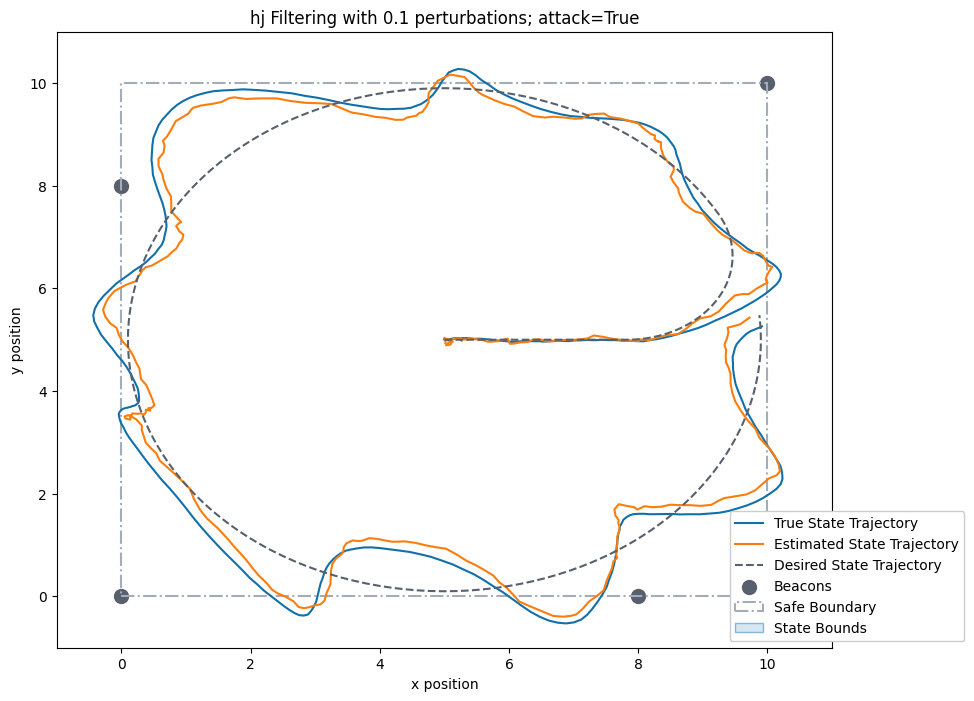

In [49]:
hj_history_atk = run_simulation(hjnnv_filter, seed=0, epsilon=epsilon, smoothing=smoothing, filter_type="hj", traj_type="spiral", attack=True)
plot_trajectory(hj_history_atk, dynamics)

Step 0: Filter execution time: 0.00630 seconds
Step 1: Filter execution time: 0.00693 seconds
Step 2: Filter execution time: 0.00515 seconds
Step 3: Filter execution time: 0.00628 seconds
Step 4: Filter execution time: 0.00544 seconds
Step 5: Filter execution time: 0.00555 seconds
Step 6: Filter execution time: 0.00467 seconds
Step 7: Filter execution time: 0.00529 seconds
Step 8: Filter execution time: 0.00492 seconds
Step 9: Filter execution time: 0.00550 seconds
Step 10: Filter execution time: 0.00605 seconds
Step 11: Filter execution time: 0.00539 seconds
Step 12: Filter execution time: 0.00518 seconds
Step 13: Filter execution time: 0.00595 seconds
Step 14: Filter execution time: 0.00609 seconds
Step 15: Filter execution time: 0.00616 seconds
Step 16: Filter execution time: 0.00649 seconds
Step 17: Filter execution time: 0.00546 seconds
Step 18: Filter execution time: 0.00667 seconds
Step 19: Filter execution time: 0.00550 seconds
Step 20: Filter execution time: 0.00574 seconds
St

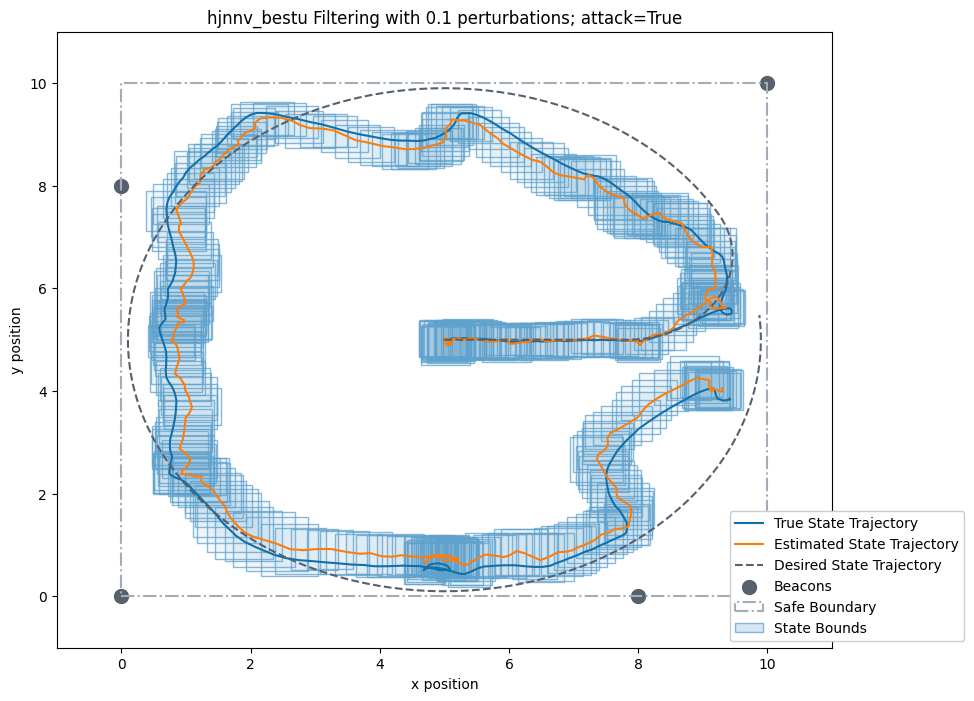

In [50]:
hjnnv_history_atk = run_simulation(hjnnv_filter, seed=0, epsilon=epsilon, smoothing=smoothing, filter_type="hjnnv_bestu", traj_type="spiral", attack=True)
plot_trajectory(hjnnv_history_atk, dynamics)

Step 0: Filter execution time: 0.00313 seconds
Step 1: Filter execution time: 0.00299 seconds
Step 2: Filter execution time: 0.00303 seconds
Step 3: Filter execution time: 0.00308 seconds
Step 4: Filter execution time: 0.00277 seconds
Step 5: Filter execution time: 0.00286 seconds
Step 6: Filter execution time: 0.00273 seconds
Step 7: Filter execution time: 0.00339 seconds
Step 8: Filter execution time: 0.00278 seconds
Step 9: Filter execution time: 0.00228 seconds
Step 10: Filter execution time: 0.00262 seconds
Step 11: Filter execution time: 0.00304 seconds
Step 12: Filter execution time: 0.00321 seconds
Step 13: Filter execution time: 0.00257 seconds
Step 14: Filter execution time: 0.00285 seconds
Step 15: Filter execution time: 0.00226 seconds
Step 16: Filter execution time: 0.00306 seconds
Step 17: Filter execution time: 0.00330 seconds
Step 18: Filter execution time: 0.00301 seconds
Step 19: Filter execution time: 0.00331 seconds
Step 20: Filter execution time: 0.00328 seconds
St

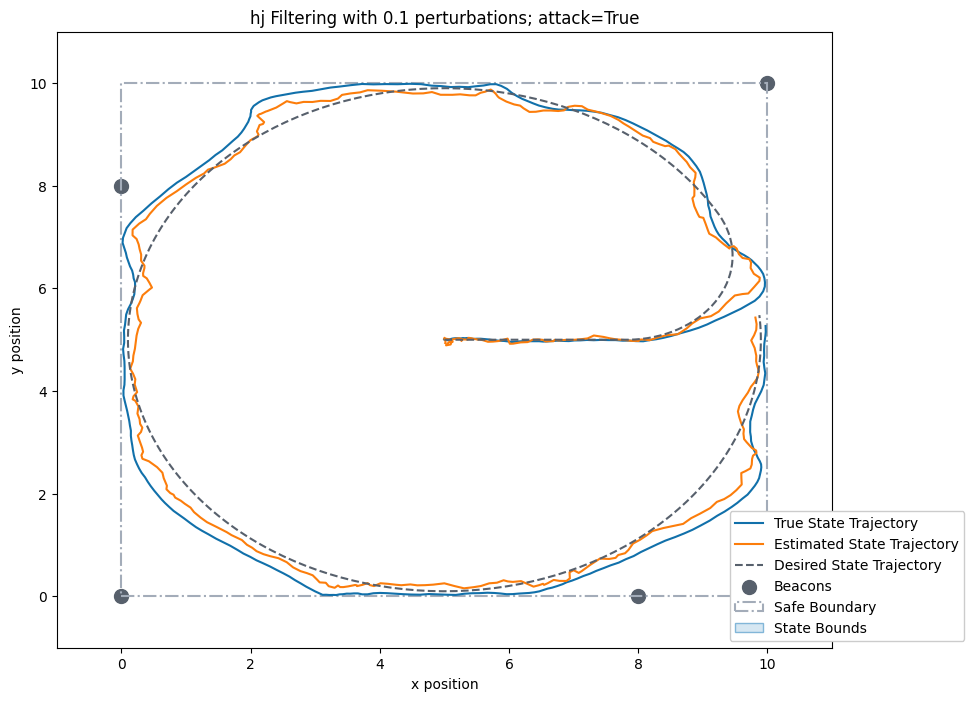

In [48]:
hj_history_atk = run_simulation(hjnnv_filter, seed=0, epsilon=epsilon, smoothing=smoothing, filter_type="hj", traj_type="spiral", attack=True, hj_mode="gt")
plot_trajectory(hj_history_atk, dynamics)